In [2]:
try:
    import warnings

    import json
    import math
    import os
    from urllib.parse import urlparse

    import geopandas as gpd
    import libpysal as ps
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import plotly.graph_objs as go
    import pysal
    import seaborn as sns
    import statsmodels.api as sm
    from esda.moran import Moran, Moran_Local
    from libpysal.weights import Queen
    from matplotlib import image as mpimg
    from mgwr.gwr import GWR, MGWR
    from mgwr.sel_bw import Sel_BW
    from requests import get
    from splot.esda import lisa_cluster
    from spreg import GM_Error_Het
except ImportError:
    !pip install pandas geopandas libpysal matplotlib pysal seaborn statsmodels mgwr splot requests plotly esda spreg

warnings.filterwarnings("ignore")




In [3]:
import warnings

warnings.filterwarnings("ignore")
import json
import math
import os
from urllib.parse import urlparse

import geopandas as gpd
import libpysal as ps
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import pysal
import seaborn as sns
import statsmodels.api as sm
from esda.moran import Moran, Moran_Local
from libpysal.weights import Queen
from matplotlib import image as mpimg
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from requests import get
from splot.esda import lisa_cluster
from spreg import GM_Error_Het

In [4]:
# Function to download file from remote
# Adapted from CASA0013


def cache_data(src: str, dest: str) -> str:
    """
    Create a folder to store file from URL.
    If folder doesn't already exists, then create one, before writing the file.

    src : URL
    dest : location on local drive
    """
    url = urlparse(src)  # We assume that this is some kind of valid URL
    fn = os.path.split(url.path)[-1]  # Extract the filename
    dfn = os.path.join(dest, fn)  # Destination filename as path

    if not os.path.isfile(dfn):
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
        print("\tDone downloading...")
    else:
        print(f"Found {dfn} locally!")
    return dfn

In [5]:
# Function to create bivariate chropleth map
# Adapted from: https://www.kaggle.com/code/yotkadata/bivariate-choropleth-map-using-plotly
"""
Function to set default variables
"""


def conf_defaults():
    # Define some variables for later use
    conf = {
        "plot_title": "Bivariate choropleth map using Ploty",  # Title text
        "plot_title_size": 20,  # Font size of the title
        "width": 1000,  # Width of the final map container
        "ratio": 0.8,  # Ratio of height to width
        "center_lat": 0,  # Latitude of the center of the map
        "center_lon": 0,  # Longitude of the center of the map
        "map_zoom": 3,  # Zoom factor of the map
        "hover_x_label": "Label x variable",  # Label to appear on hover
        "hover_y_label": "Label y variable",  # Label to appear on hover
        "borders_width": 0.5,  # Width of the geographic entity borders
        "borders_color": "#f8f8f8",  # Color of the geographic entity borders
        # Define settings for the legend
        "top": 1,  # Vertical position of the top right corner (0: bottom, 1: top)
        "right": 1,  # Horizontal position of the top right corner (0: left, 1: right)
        "box_w": 0.04,  # Width of each rectangle
        "box_h": 0.04,  # Height of each rectangle
        "line_color": "#f8f8f8",  # Color of the rectagles' borders
        "line_width": 0,  # Width of the rectagles' borders
        "legend_x_label": "Higher x value",  # x variable label for the legend
        "legend_y_label": "Higher y value",  # y variable label for the legend
        "legend_font_size": 9,  # Legend font size
        "legend_font_color": "#333",  # Legend font color
    }
    # Calculate height
    conf["height"] = conf["width"] * conf["ratio"]

    return conf


"""
Function to recalculate values in case width is changed
"""


def recalc_vars(new_width, variables, conf=conf_defaults()):
    # Calculate the factor of the changed width
    factor = new_width / 1000

    # Apply factor to all variables that have been passed to the function
    for var in variables:
        if var == "map_zoom":
            # Calculate the zoom factor
            # Mapbox zoom is based on a log scale. map_zoom needs to be set
            # to value ideal for our map at 1000px.
            # So factor = 2 ^ (zoom - map_zoom) and zoom = log(factor) / log(2) + map_zoom
            conf[var] = math.log(factor) / math.log(2) + conf[var]
        else:
            conf[var] = conf[var] * factor

    return conf

"""
Function that assigns a value (x) to one of three bins (0, 1, 2).
The break points for the bins can be defined by break_1 and break_2.
"""

def set_interval_value(x, break_1, break_2):
    if x <= break_1:
        return 0
    elif break_1 < x <= break_2:
        return 1
    else:
        return 2


"""
Function that adds a column 'biv_bins' to the dataframe containing the 
position in the 9-color matrix for the bivariate colors
    
Arguments:
    df: Dataframe
    x: Name of the column containing values of the first variable
    y: Name of the column containing values of the second variable

"""


def prepare_df(df, x="x", y="y"):
    # Check if arguments match all requirements
    if df[x].shape[0] != df[y].shape[0]:
        raise ValueError(
            "ERROR: The list of x and y coordinates must have the same length."
        )

    # Calculate break points at percentiles 33 and 66
    x_breaks = np.percentile(df[x], [33, 66])
    y_breaks = np.percentile(df[y], [33, 66])

    # Assign values of both variables to one of three bins (0, 1, 2)
    x_bins = [
        set_interval_value(value_x, x_breaks[0], x_breaks[1]) for value_x in df[x]
    ]
    y_bins = [
        set_interval_value(value_y, y_breaks[0], y_breaks[1]) for value_y in df[y]
    ]

    # Calculate the position of each x/y value pair in the 9-color matrix of bivariate colors
    df["biv_bins"] = [
        int(value_x + 3 * value_y) for value_x, value_y in zip(x_bins, y_bins)
    ]

    return df


"""
Function to create a color square containig the 9 colors to be used as a legend
"""


def create_legend(fig, colors, conf=conf_defaults()):
    # Reverse the order of colors
    legend_colors = colors[:]
    legend_colors.reverse()

    # Calculate coordinates for all nine rectangles
    coord = []

    # Adapt height to ratio to get squares
    width = conf["box_w"]
    height = conf["box_h"] / conf["ratio"]

    # Start looping through rows and columns to calculate corners the squares
    for row in range(1, 4):
        for col in range(1, 4):
            coord.append(
                {
                    "x0": round(conf["right"] - (col - 1) * width, 4),
                    "y0": round(conf["top"] - (row - 1) * height, 4),
                    "x1": round(conf["right"] - col * width, 4),
                    "y1": round(conf["top"] - row * height, 4),
                }
            )

    # Create shapes (rectangles)
    for i, value in enumerate(coord):
        # Add rectangle
        fig.add_shape(
            go.layout.Shape(
                type="rect",
                fillcolor=legend_colors[i],
                line=dict(
                    color=conf["line_color"],
                    width=conf["line_width"],
                ),
                xref="paper",
                yref="paper",
                xanchor="right",
                yanchor="top",
                x0=coord[i]["x0"],
                y0=coord[i]["y0"],
                x1=coord[i]["x1"],
                y1=coord[i]["y1"],
            )
        )

        # Add text for first variable
        fig.add_annotation(
            xref="paper",
            yref="paper",
            xanchor="left",
            yanchor="top",
            x=coord[8]["x1"],
            y=coord[8]["y1"],
            showarrow=False,
            text=conf["legend_x_label"] + " 🠒",
            font=dict(
                color=conf["legend_font_color"],
                size=conf["legend_font_size"],
            ),
            borderpad=0,
        )

        # Add text for second variable
        fig.add_annotation(
            xref="paper",
            yref="paper",
            xanchor="right",
            yanchor="bottom",
            x=coord[8]["x1"],
            y=coord[8]["y1"],
            showarrow=False,
            text=conf["legend_y_label"] + " 🠒",
            font=dict(
                color=conf["legend_font_color"],
                size=conf["legend_font_size"],
            ),
            textangle=270,
            borderpad=0,
        )

    return fig


"""
Function to create the map

Arguments:
    df: The dataframe that contains all the necessary columns
    colors: List of 9 blended colors
    x: Name of the column that contains values of first variable (defaults to 'x')
    y: Name of the column that contains values of second variable (defaults to 'y')
    ids: Name of the column that contains ids that connect the data to the GeoJSON (defaults to 'id')
    name: Name of the column conatining the geographic entity to be displayed as a description (defaults to 'name')
"""


def create_bivariate_map(
    df, colors, geojson, x="x", y="y", ids="id", name="name", conf=conf_defaults()
):
    if len(colors) != 9:
        raise ValueError(
            "ERROR: The list of bivariate colors must have a length eaqual to 9."
        )

    # Recalculate values if width differs from default
    if not conf["width"] == 1000:
        conf = recalc_vars(
            conf["width"],
            ["height", "plot_title_size", "legend_font_size", "map_zoom"],
            conf,
        )

    # Prepare the dataframe with the necessary information for our bivariate map
    df_plot = prepare_df(df, x, y)

    # Create the figure
    fig = go.Figure(
        go.Choroplethmapbox(
            geojson=geojson,
            locations=df_plot[ids],
            z=df_plot["biv_bins"],
            marker_line_width=0.5,
            colorscale=[
                [0 / 8, colors[0]],
                [1 / 8, colors[1]],
                [2 / 8, colors[2]],
                [3 / 8, colors[3]],
                [4 / 8, colors[4]],
                [5 / 8, colors[5]],
                [6 / 8, colors[6]],
                [7 / 8, colors[7]],
                [8 / 8, colors[8]],
            ],
            customdata=df_plot[
                [name, ids, x, y]
            ],  # Add data to be used in hovertemplate
            hovertemplate="<br>".join(
                [  # Data to be displayed on hover
                    "<b>%{customdata[0]}</b> (ID: %{customdata[1]})",
                    conf["hover_x_label"] + ": %{customdata[2]}",
                    conf["hover_y_label"] + ": %{customdata[3]}",
                    "<extra></extra>",  # Remove secondary information
                ]
            ),
        )
    )

    # Add some more details
    fig.update_layout(
        title=dict(
            text=conf["plot_title"],
            font=dict(
                size=conf["plot_title_size"],
            ),
        ),
        mapbox_style="white-bg",
        width=conf["width"],
        height=conf["height"],
        autosize=True,
        mapbox=dict(
            center=dict(
                lat=conf["center_lat"], lon=conf["center_lon"]
            ),  # Set map center
            zoom=conf["map_zoom"],  # Set zoom
        ),
    )

    fig.update_traces(
        marker_line_width=conf[
            "borders_width"
        ],  # Width of the geographic entity borders
        marker_line_color=conf[
            "borders_color"
        ],  # Color of the geographic entity borders
        showscale=False,  # Hide the colorscale
    )

    # Add the legend
    fig = create_legend(fig, colors, conf)

    return fig


# Define sets of 9 colors to be used
# Order: bottom-left, bottom-center, bottom-right, center-left, center-center, center-right, top-left, top-center, top-right
color_sets = {
    "pink-blue": [
        "#e8e8e8",
        "#ace4e4",
        "#5ac8c8",
        "#dfb0d6",
        "#a5add3",
        "#5698b9",
        "#be64ac",
        "#8c62aa",
        "#3b4994",
    ],
    "teal-red": [
        "#e8e8e8",
        "#e4acac",
        "#c85a5a",
        "#b0d5df",
        "#ad9ea5",
        "#985356",
        "#64acbe",
        "#627f8c",
        "#574249",
    ],
    "blue-orange": [
        "#fef1e4",
        "#fab186",
        "#f3742d",
        "#97d0e7",
        "#b0988c",
        "#ab5f37",
        "#18aee5",
        "#407b8f",
        "#5c473d",
    ],
}

In [6]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


def drop_column_using_vif_(df, thresh=5):
    """
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    """
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series(
            [
                variance_inflation_factor(df_with_const.values, i)
                for i in range(df_with_const.shape[1])
            ],
            name="VIF",
            index=df_with_const.columns,
        ).to_frame()

        # drop the const
        vif_df = vif_df.drop("const")

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print("Dropping: {}".format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

### DATA WRANGLING

In [7]:
# Define paths for download
ddir = os.path.join("data", "geo")  # destination directory
spath = "https://github.com/jreades/i2p/blob/master/data/src/"  # source path
spath_db = "https://www.dropbox.com/scl/fi/"  # source path for dropbox
host = "http://orca.casa.ucl.ac.uk"
path = "~jreades/data"

In [8]:
# LSOA (London) data concatenated from multiple datasets from London Datastore,
lsoa_stat = pd.read_csv(
    cache_data(
        spath_db
        + "8zc0g09rlf1yhj6j7yn6n/lsoa_full.csv?rlkey=yopr4hv017rr3iv4e2zus0ifz&dl=1",
        ddir,
    ),
    low_memory=False,
)

Found data\geo\lsoa_full.csv locally!


In [9]:
#| output: false

# Read in shapefiles (2 mins)
water = gpd.read_file(cache_data(spath + "Water.gpkg?raw=true", ddir))
green = gpd.read_file(cache_data(spath + "Greenspace.gpkg?raw=true", ddir))
boros = gpd.read_file(cache_data(spath + "Boroughs.gpkg?raw=true", ddir))
lsoa = gpd.read_file(
    cache_data(
        spath_db
        + "u367zlorie8vuluugy2fr/lsoa_london.gpkg?rlkey=rc7rdnlfdmzfgy5q7ujz9pnwj&dl=1",
        ddir,
    )
)

Found data\geo\Water.gpkg locally!
Found data\geo\Greenspace.gpkg locally!
Found data\geo\Boroughs.gpkg locally!
Found data\geo\lsoa_london.gpkg locally!


In [10]:
# import population data from lsoa_stat to lsoa
lsoa = lsoa.merge(lsoa_stat[['LSOA code','All usual residents']],left_on='LSOA21CD',right_on='LSOA code',how='left')
lsoa.rename(columns={'All usual residents':'population'},inplace=True)
lsoa.drop('LSOA code',axis=1,inplace=True)

In [11]:
# # read in the shapefile stops-stations.geojson, only keep the columns 'full_id' and 'geometry'
# transit_stop = gpd.read_file("stops-stations1.geojson")

# # drop all columns with null values
# transit_stop_cleaned = transit_stop.dropna(axis=1)
# transit_stop_cleaned.head()

# # Export the cleaned transit stop data to a geojson file
# transit_stop_cleaned.to_file("transit_stop_cleaned.geojson", driver='GeoJSON')

In [12]:
#Read in the shapefile transit_stop_cleaned.geojson
transit_stop_cleaned = gpd.read_file("transit_stop_cleaned.geojson")

In [13]:
# spatial join between transit_stop_cleaned and lsoa, summing the number of stops in each LSOA

dfsjoin = gpd.sjoin(lsoa, transit_stop_cleaned) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='LSOA21CD',columns='osm_type',aggfunc={'osm_type':len})
dfpivot.columns = dfpivot.columns.droplevel()
dfpolynew = lsoa.merge(dfpivot, how='left', on='LSOA21CD')

In [14]:
## Get Transit stops stat per LSOA

# fill the NaN values with 0
lsoa_merge = dfpolynew.fillna(0)

# rename columns node as num_stops
lsoa_merge.rename(columns={'node':'num_stops'},inplace=True)

# Find row with Max value for num_stops, change it to median of num_stops
lsoa_merge.loc[lsoa_merge['num_stops'].idxmax(),'num_stops'] = lsoa_merge['num_stops'].median()

# calculate the number of stops per 1000 residents
lsoa_merge['stops_per_1000'] = (lsoa_merge['num_stops']/lsoa_merge['population'])*1000


In [15]:
## Get Bike docks stat per LSOA

# import bike_count_lsoa.csv
df_bike = pd.read_csv('bike_count_lsoa.csv')

# merge df_bike to lsoa_merge2 on LSOA21CD and LSOA11CD, only take 'count'
lsoa_merge1 = lsoa_merge.merge(df_bike[['LSOA11CD','count']], left_on='LSOA21CD', right_on='LSOA11CD', how='left')
lsoa_merge1.rename(columns={'count':'num_bike_docks'}, inplace=True)
lsoa_merge1.drop('LSOA11CD', axis=1, inplace=True)

# calculate the number of docks per 1000 residents
lsoa_merge1['bike_docks_per_1000'] = (lsoa_merge1['num_bike_docks']/lsoa_merge1['population'])*1000


In [16]:
## Get PCA per LSOA

# import Dataframe_After_PCA.csv
df_pca = pd.read_csv('Dataframe_After_PCA.csv')

# merge lsoa with df_pca on LSOA21CD and lsoa_code
lsoa_merge2 = lsoa_merge1.merge(df_pca, left_on='LSOA21CD', right_on='lsoa_code', how='left')
lsoa_merge2.drop('lsoa_code', axis=1, inplace=True)

In [17]:
# Extract columns with dimensions in name from lsoa_stat and lsoa code

lsoa_stat_imd = lsoa_stat[['LSOA code','2 dimensions','All usual residents']]
lsoa_stat_imd['MID_2_dim_share'] = lsoa_stat_imd['2 dimensions']/lsoa_stat_imd['All usual residents']
lsoa_stat_imd.rename(columns={'2 dimensions':'MID_2_dim','All usual residents':'population'},inplace=True)
# resize MID_2_dim_share to 0-1
lsoa_stat_imd['MID_2_dim_share'] = lsoa_stat_imd['MID_2_dim_share']/lsoa_stat_imd['MID_2_dim_share'].max()
lsoa_stat_imd.head()

# merge lsoa_stat_imd to lsoa_merge3 on LSOA21CD
lsoa_merge3 = lsoa_merge2.merge(lsoa_stat_imd[['LSOA code','MID_2_dim_share']], left_on='LSOA21CD', right_on='LSOA code', how='left')
lsoa_merge3.drop(['LSOA code'], axis=1, inplace=True)
lsoa_merge3.head()

,OBJECTID,LSOA21CD,LSOA21NM,GlobalID,geometry,population,num_stops,stops_per_1000,num_bike_docks,bike_docks_per_1000,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,MID_2_dim_share
0,1,E01000001,City of London 001A,f1865556-4e62-48e3-a025-d93a40f15e46,"POLYGON ((532105.312 182010.574, 532162.491 18...",1473,0.0,0.00000,12.0,8.146640,...,-1.242830,-2.226991,1.061538,-1.146655,-2.640415,-2.534559,0.085303,0.995044,1.164273,0.173177
1,2,E01000002,City of London 001B,83e78aad-ee05-44a5-a8d3-077de6ed4053,"POLYGON ((532634.497 181926.016, 532619.141 18...",1382,0.0,0.00000,31.0,22.431259,...,-1.413166,-0.765784,-0.293674,-0.867079,-3.133679,-2.025945,0.856210,1.978247,0.665477,0.161508
2,3,E01000003,City of London 001C,69c457df-229e-4446-9577-95ac1c9be694,"POLYGON ((532135.138 182198.131, 532158.250 18...",1613,0.0,0.00000,9.0,5.579665,...,-0.928619,0.005849,-1.239121,-1.799013,-1.417872,-1.668924,-0.420351,3.284014,2.703339,0.543628
3,4,E01000005,City of London 001E,d537d59f-237a-45ed-a514-b0ab2a93e510,"POLYGON ((533808.018 180767.774, 533649.037 18...",1111,3.0,2.70027,24.0,21.602160,...,0.414551,-0.721126,1.003400,-0.456897,-0.120670,-1.022698,1.993269,2.063849,-0.669040,0.681637
4,5,E01000006,Barking and Dagenham 016A,8d0081fe-69e2-48ac-aaf9-fd270d60e339,"POLYGON ((545122.049 184314.931, 545271.849 18...",1840,0.0,0.00000,0.0,0.000000,...,0.508499,-0.279450,0.135136,-0.451405,0.005289,-0.165722,-0.557058,1.190223,1.216854,0.320596


In [22]:
# import daqi_by_lsoa.geojson

daqi = gpd.read_file('avg_daqi_by_lsoa.geojson')

# merge lsoa with daqi on LSOA21CD and lsoa_code
lsoa_merge4 = lsoa_merge3.merge(daqi[['avg_daqi_mean','LSOA21CD']], on='LSOA21CD', how='left')



In [24]:
# extract lsoa_merge3 to geojson
lsoa_merge4.to_file("data_full_by_lsoa.geojson", driver='GeoJSON')

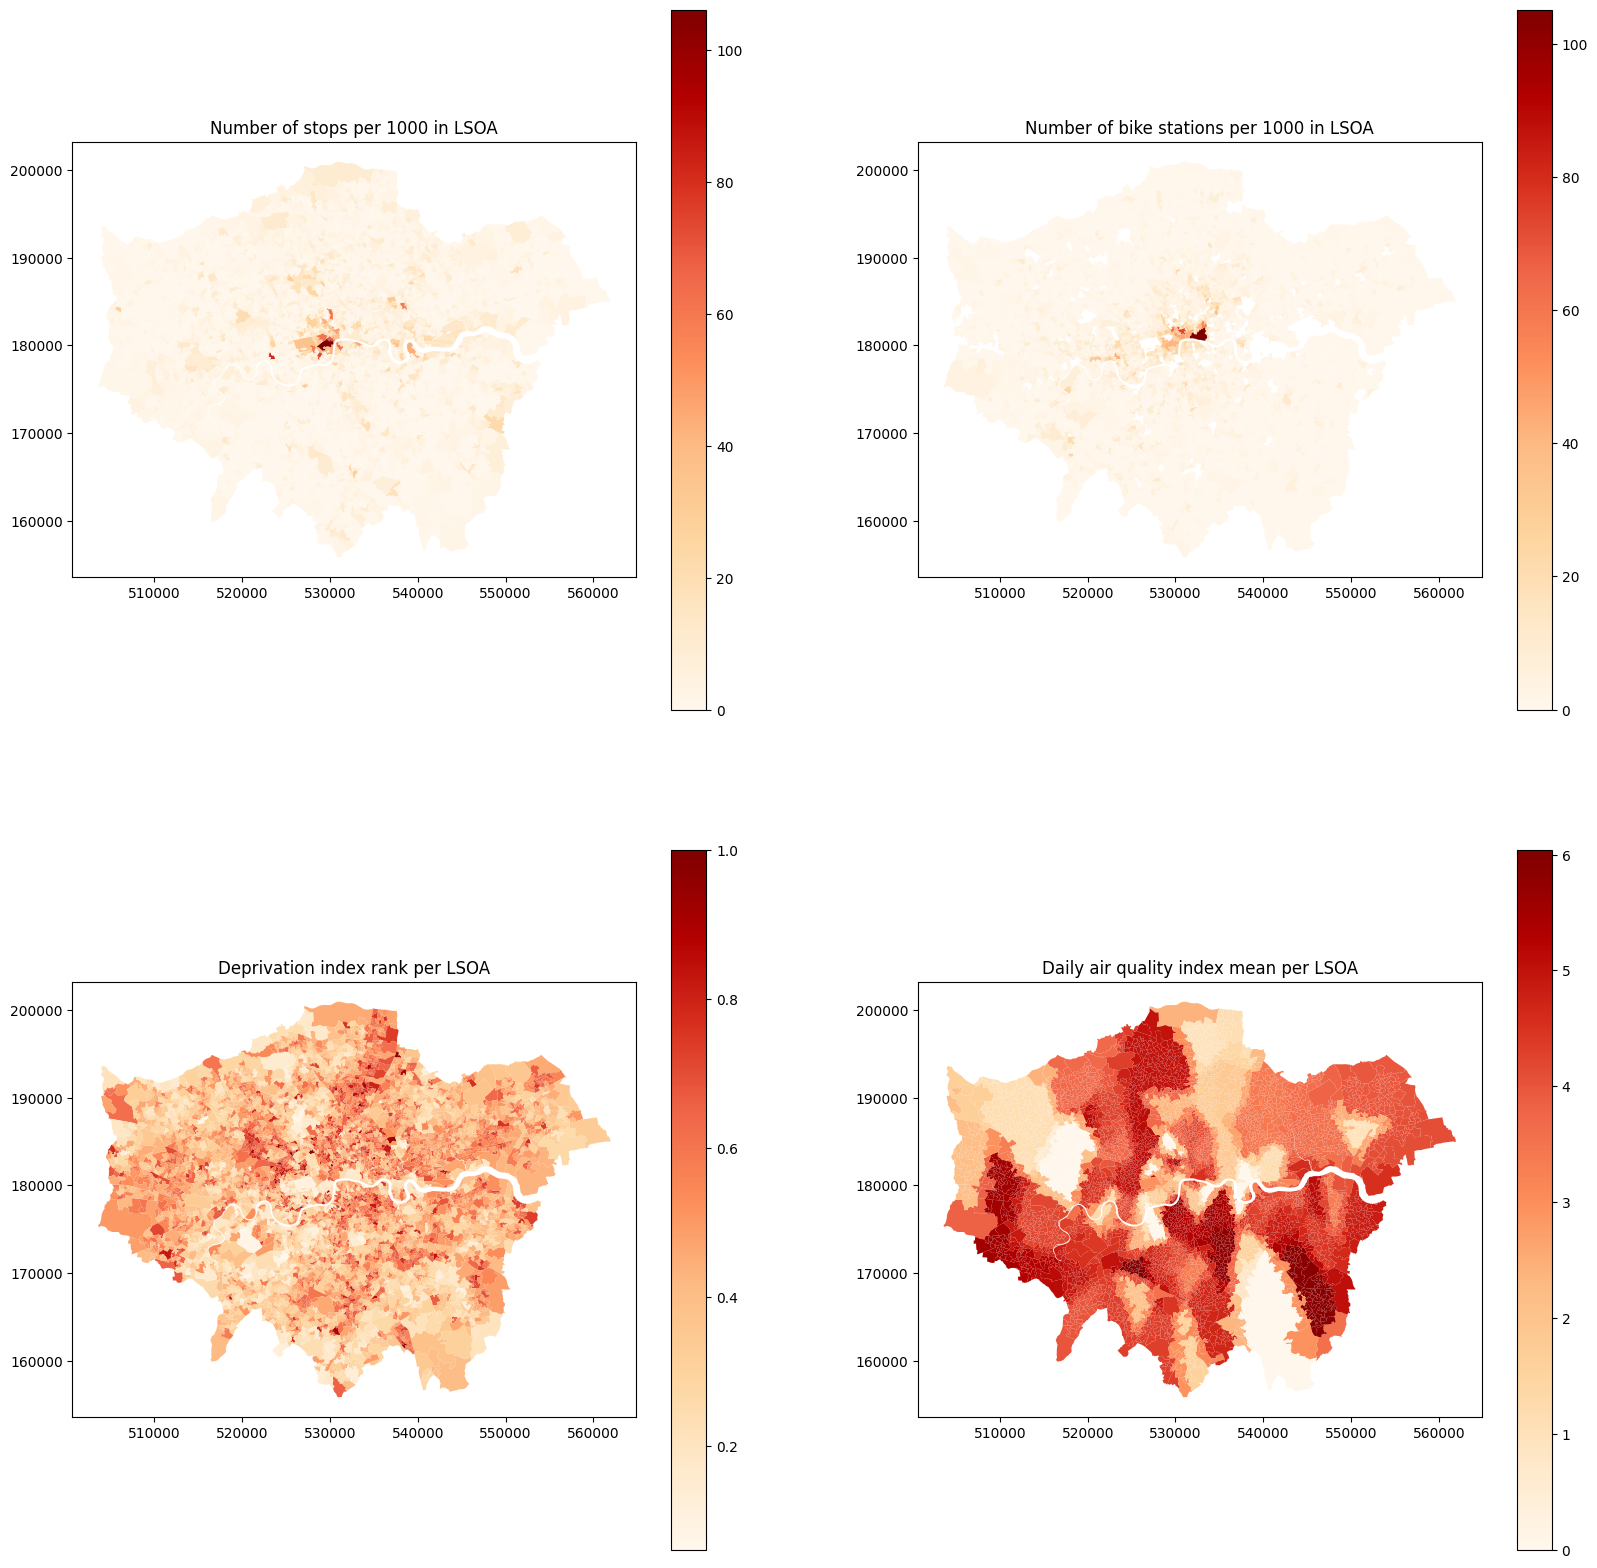

In [25]:
# Map all variables of lsoa_merge4 in a 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

lsoa_merge4.plot(column='stops_per_1000', cmap='OrRd', linewidth=0, ax=ax[0,0], edgecolor='0.8', legend=True)
lsoa_merge4.plot(column='bike_docks_per_1000', cmap='OrRd', linewidth=0, ax=ax[0,1], edgecolor='0.8', legend=True)
lsoa_merge4.plot(column='MID_2_dim_share', cmap='OrRd', linewidth=0, ax=ax[1,0], edgecolor='0.8', legend=True)
lsoa_merge4.plot(column='avg_daqi_mean', cmap='OrRd', linewidth=0, ax=ax[1,1], edgecolor='0.8', legend=True)

ax[0,0].set_title('Number of stops per 1000 in LSOA')
ax[0,1].set_title('Number of bike stations per 1000 in LSOA')
ax[1,0].set_title('Deprivation index rank per LSOA')
ax[1,1].set_title('Daily air quality index mean per LSOA')

plt.show()

In [26]:
lsoa_merge4.columns

Index(['OBJECTID', 'LSOA21CD', 'LSOA21NM', 'GlobalID', 'geometry',
       'population', 'num_stops', 'stops_per_1000', 'num_bike_docks',
       'bike_docks_per_1000', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16',
       'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24',
       'MID_2_dim_share', 'avg_daqi_mean'],
      dtype='object')

In [27]:
# COrrelation matrix of all variables

lsoa_merge4[['stops_per_1000','bike_docks_per_1000','MID_2_dim_share','avg_daqi_mean']].corr()

,stops_per_1000,bike_docks_per_1000,MID_2_dim_share,avg_daqi_mean
stops_per_1000,1.000000,0.469039,0.039589,-0.048484
bike_docks_per_1000,0.469039,1.000000,0.036014,0.003458
MID_2_dim_share,0.039589,0.036014,1.000000,-0.022576
avg_daqi_mean,-0.048484,0.003458,-0.022576,1.000000


### REGRESSION

In [41]:
regressiondata = lsoa_merge4.copy()
# change index to LSOA21CD
regressiondata = regressiondata.set_index('LSOA21CD')

# drop geometry and OBJECTID

regressiondata = regressiondata.drop(columns='geometry')
regressiondata = regressiondata.drop(columns='OBJECTID')

# Keep only numeric columns

regressiondata = regressiondata.select_dtypes(include='number')

# # fill na with median of the column

regressiondata = regressiondata.fillna(regressiondata.median())


In [42]:
regressiondata.columns

Index(['population', 'num_stops', 'stops_per_1000', 'num_bike_docks',
       'bike_docks_per_1000', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16',
       'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24',
       'MID_2_dim_share', 'avg_daqi_mean'],
      dtype='object')

In [43]:
#| output: false

# drop crime related columns to check for multicollinearity
regressiondata_VIF = regressiondata.drop(
    [col for col in regressiondata.columns if "crime" in col], axis=1
)
# drop columns with high VIF
regressiondata_VIF = drop_column_using_vif_(regressiondata_VIF)
selected_cols = regressiondata_VIF.columns.tolist()

Dropping: population
Dropping: num_bike_docks
Dropping: num_stops
Dropping: MID_2_dim_share


In [44]:
# remove avg_daqi_mean from selected_cols
selected_cols = [col for col in selected_cols if col != 'avg_daqi_mean']
selected_cols

['stops_per_1000',
 'bike_docks_per_1000',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 'PC20',
 'PC21',
 'PC22',
 'PC23',
 'PC24']

In [45]:
OLSmodel = sm.OLS(
        endog=regressiondata['avg_daqi_mean'], 
        exog=sm.add_constant(regressiondata[selected_cols]),
    )
result = OLSmodel.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_daqi_mean   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     13.24
Date:                Thu, 22 Feb 2024   Prob (F-statistic):           3.57e-55
Time:                        12:46:52   Log-Likelihood:                -9237.9
No. Observations:                4994   AIC:                         1.853e+04
Df Residuals:                    4967   BIC:                         1.871e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.3799    

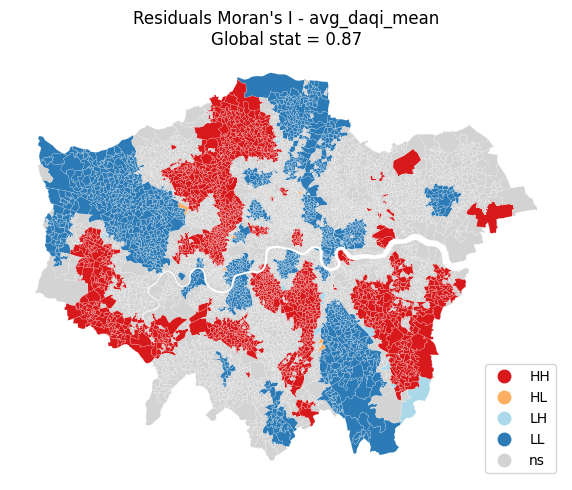

In [46]:
# Local Moran's I for residual of OLSmodel

# Create spatial weights matrix
w = Queen.from_dataframe(lsoa)
w.transform = "r"

residuals = result.resid
moran = Moran(residuals, w)
moran_loc = Moran_Local(residuals, w)
lisa_cluster(
    moran_loc, lsoa, p=0.05, figsize=(7, 5), legend_kwds={"loc": "lower right"}
)
plt.title(f"Residuals Moran's I - {OLSmodel.endog_names}\nGlobal stat = {moran.I:.2f}")
plt.tight_layout()
plt.show()

In [47]:
# Prepare dataset inputs
g_y = regressiondata["avg_daqi_mean"].values.reshape((-1, 1)) # add y column
g_X = regressiondata[selected_cols].values  # add x columnx
lsoa_cen = lsoa.centroid.get_coordinates()
u = lsoa_cen["x"]
v = lsoa_cen["y"]
g_coords = list(zip(u, v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

# Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
# gwr_bw = gwr_selector.search(bw_min=2)
# print(gwr_bw)
gwr_bw = 504  # I calibrated this
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

# Add Paramaters back to geo dataframe for mapping
lsoa["gwr_intercept"] = gwr_results.params[:, 0]
for i in range(len(selected_cols)):
    lsoa["gwr_" + selected_cols[i]] = gwr_results.params[:, i + 1]

# Filter Insignificant coefficients alpha 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha=0.05)

In [54]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                4994
Number of covariates:                                                    27

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4670.235
Log-likelihood:                                                   -6918.811
AIC:                                                              13891.621
AICc:                                                             13893.949
BIC:                                                             -37628.699
R2:                                                                   0.065
Adj. R2:                                                              0.060

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [49]:
lsoa.columns

Index(['OBJECTID', 'LSOA21CD', 'LSOA21NM', 'GlobalID', 'geometry',
       'population', 'gwr_intercept', 'gwr_stops_per_1000',
       'gwr_bike_docks_per_1000', 'gwr_PC1', 'gwr_PC2', 'gwr_PC3', 'gwr_PC4',
       'gwr_PC5', 'gwr_PC6', 'gwr_PC7', 'gwr_PC8', 'gwr_PC9', 'gwr_PC10',
       'gwr_PC11', 'gwr_PC12', 'gwr_PC13', 'gwr_PC14', 'gwr_PC15', 'gwr_PC16',
       'gwr_PC17', 'gwr_PC18', 'gwr_PC19', 'gwr_PC20', 'gwr_PC21', 'gwr_PC22',
       'gwr_PC23', 'gwr_PC24'],
      dtype='object')

In [80]:
lsoa.to_file("lsoa_gwr.geojson", driver='GeoJSON')

Text(0.5, 0, 'Geographically weighted effect of transit facilities in predicting air quality')

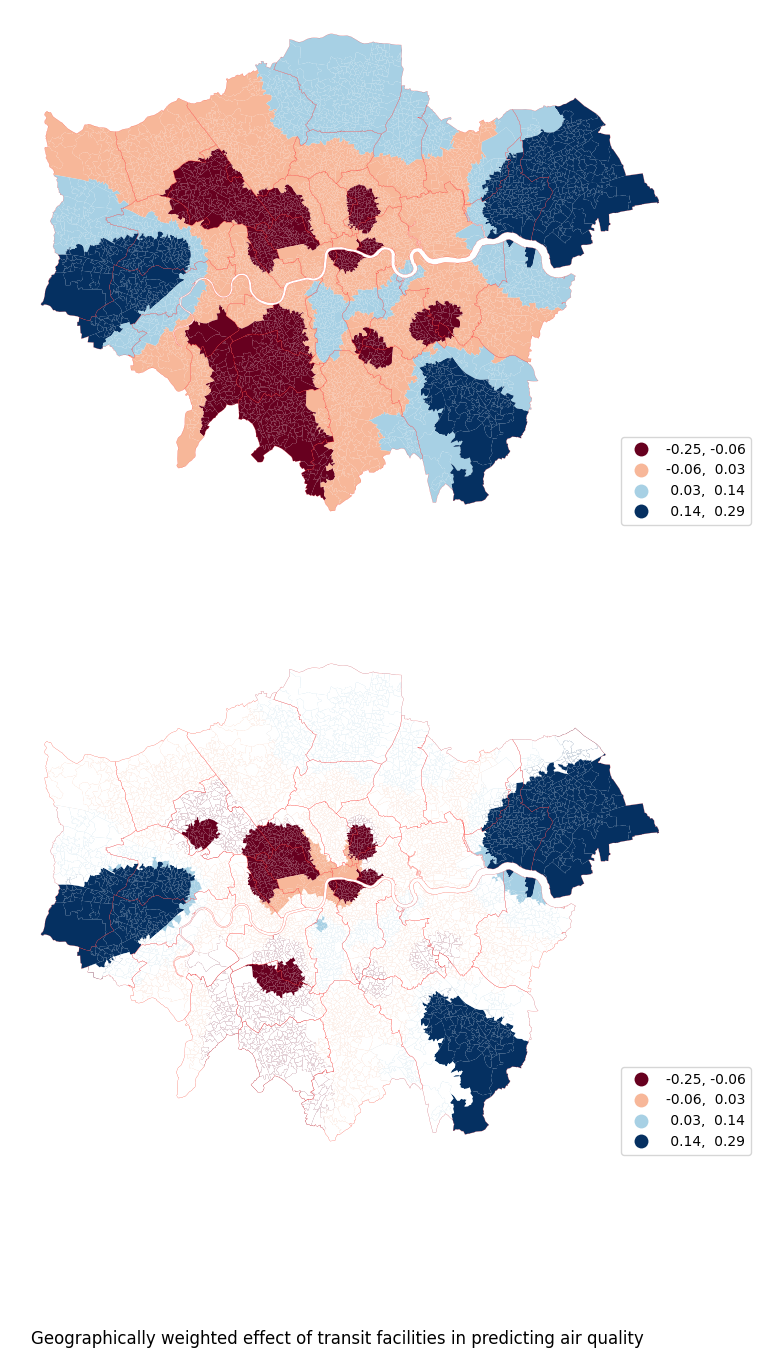

In [79]:
# Map them both, sig coeff only
# Adapted from https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
import matplotlib.colors as mcolors

# All crime
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

lsoa.plot(
    column=f"gwr_stops_per_1000",
    cmap="RdBu",
    linewidth=0.001,
    scheme="naturalbreaks",
    k=4,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.10, 0.2)}, ax=axes[0] )

lsoa.plot(
    column=f"gwr_stops_per_1000",
    cmap="RdBu",
    linewidth=0.001,
    scheme="naturalbreaks",
    k=4,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.10, 0.2)}, ax=axes[1] )

lsoa[gwr_filtered_t[:, 1] == 0].plot(
        color="white", linewidth=0.001, edgecolor="white", ax=axes[1]
    )  # 1st variables in variable array
    
boros.plot(edgecolor="red", facecolor="None", linewidth=0.1, ax=axes[0])
boros.plot(edgecolor="red", facecolor="None", linewidth=0.1, ax=axes[1])

axes[0].set_axis_off()
axes[1].set_axis_off()

fig.suptitle(
    "Geographically weighted effect of transit facilities in predicting air quality", x=0.5, y=0
)

Text(0.5, 0, 'Geographically weighted effect of transit facilities in predicting air quality')

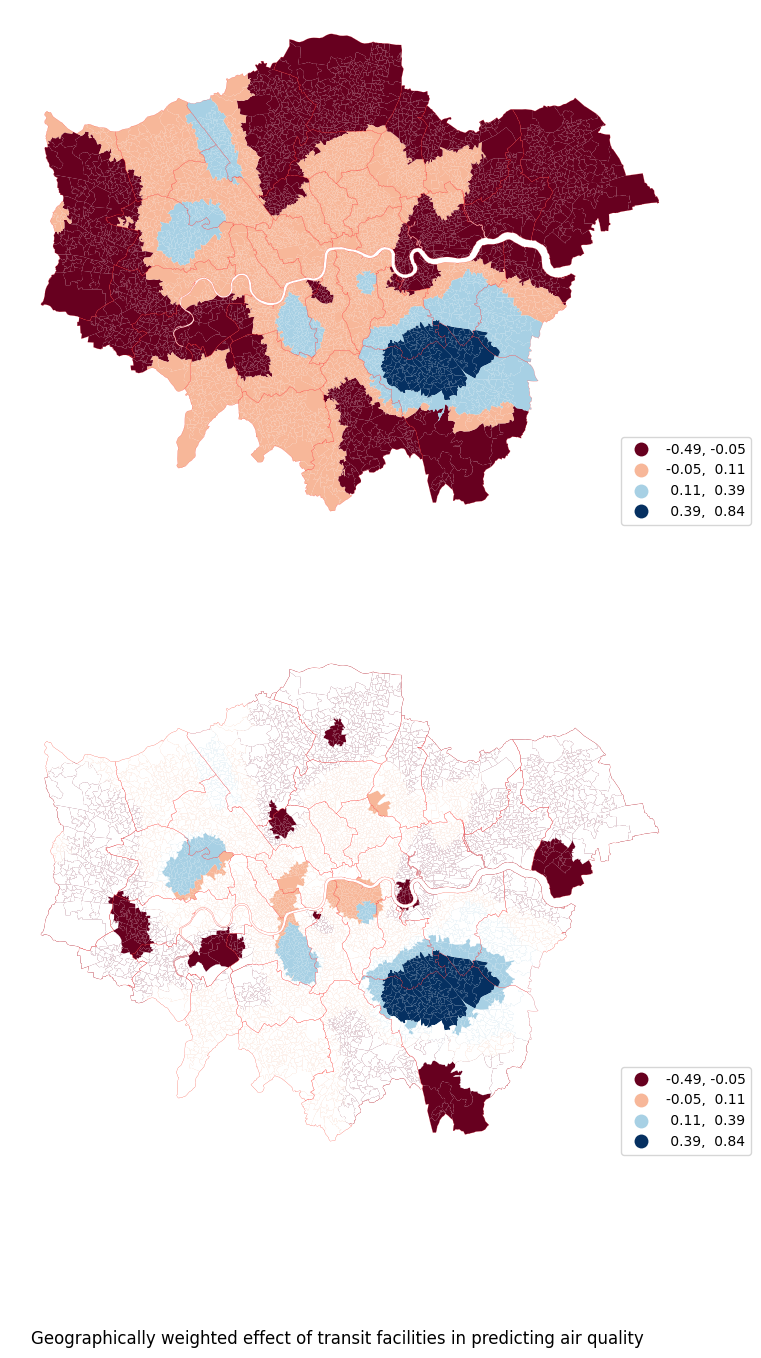

In [77]:
# Map them both, sig coeff only
# Adapted from https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
import matplotlib.colors as mcolors

# All crime
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

lsoa.plot(
    column=f"gwr_bike_docks_per_1000",
    cmap="RdBu",
    linewidth=0.001,
    scheme="naturalbreaks",
    k=4,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.10, 0.2)}, ax=axes[0] )

lsoa.plot(
    column=f"gwr_bike_docks_per_1000",
    cmap="RdBu",
    linewidth=0.001,
    scheme="naturalbreaks",
    k=4,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.10, 0.2)}, ax=axes[1] )

lsoa[gwr_filtered_t[:, 2] == 0].plot(
        color="white", linewidth=0.001, edgecolor="white", ax=axes[1]
    )  # 1st variables in variable array
    
boros.plot(edgecolor="red", facecolor="None", linewidth=0.1, ax=axes[0])
boros.plot(edgecolor="red", facecolor="None", linewidth=0.1, ax=axes[1])

# remove axis
axes[0].set_axis_off()
axes[1].set_axis_off()
fig.suptitle(
    "Geographically weighted effect of transit facilities in predicting air quality", x=0.5, y=0
)

*Note:* our log transformation has greatly treated the Heteroscedasticity of the variables, although some do remain without greatly affecting the OLS regression results.

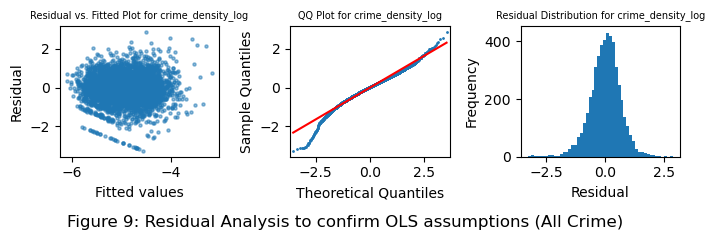

In [50]:
# # Residuals vs. Fitted plot (All Crime model)
# fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))
# # Plot the residuals vs fitted values on ax1
# axes[0].scatter(results[0].fittedvalues, results[0].resid, alpha=0.5, s=5)
# axes[0].set_xlabel(f"Fitted values")
# axes[0].set_ylabel("Residual")
# axes[0].set_title(f"Residual vs. Fitted Plot for {models[0].endog_names}", fontsize=7)

# # QQplot on ax2
# sm.qqplot(results[0].resid, line="s", markersize=1, ax=axes[1])
# axes[1].set_title(f"QQ Plot for {models[0].endog_names}", fontsize=7)

# # Residual distribution on ax3
# axes[2].hist(results[0].resid, bins=50)
# axes[2].set_xlabel("Residual")
# axes[2].set_ylabel("Frequency")
# axes[2].set_title(f"Residual Distribution for {models[0].endog_names}", fontsize=7)

# fig.suptitle(
#     "Figure 9: Residual Analysis to confirm OLS assumptions (All Crime)", x=0.5, y=0
# )
# plt.tight_layout()
# plt.show()